In [2]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import pandas as pd
import numpy as np

In [1]:
class Experimentation(object):
    def __init__(self, variables, features_conf, regression_alg):
        
        self.variables = variables
        self.features_conf = features_conf
        self.regression_alg = regression_alg
        
    def fit(self, configuration__, mode):
        self.configuration__ = configuration__
        # declaring Bee
        self.sensors = sb.Sensors(configuration__, mode, path=configuration__['DATA_FOLDER'])
        self.geography = sb.Geography(configuration__, mode, self.sensors)
        self.features = sb.Features(configuration__, mode, Sensors=self.sensors, Geography=self.geography)
        
    def initiate(self, iterations, path_to_results):
        self.scores = []
        for var in self.variables:
            for fc in self.features_conf:
                for ra in self.regression_alg:
                    features = ['dow','day','week']
                    f = self.features.get_train_features(var)
                    if 'p' in fc:
                        features += [var]
                    if 'u' in fc:
                        features += self.configuration__['osm_line_objs']+self.configuration__['osm_point_objs']
                    if 's' in fc:
                        features += [x for x in self.configuration__['Sensors__variables'] if x!= var]
                    if 'd' in fc:
                        features += ['Index of Multiple Deprivation (IMD) Score', 'Income Score (rate)',
                                       'Employment Score (rate)', 'Education, Skills and Training Score',
                                       'Crime Score', 'Total population: mid 2012 (excluding prisoners)']

                    if ra == 'rf':
                        regressor = RandomForestRegressor(n_estimators=200, max_depth=5, max_features=1)
                    elif ra == 'gb':
                        regressor = GradientBoostingRegressor(n_estimators=200, max_depth=5, max_features=1)
                    
                    r2, mse = [], []
                    imps = np.zeros([iterations, f['X'][features].shape[1]])
                    for i in range(iterations):
                        m = sb.Model(regressor).fit(f['X'][features], f['y'])
                        r2.append(m.r2)
                        mse.append(m.mse)
                        imps[i,:] = m.regressor.feature_importances_
                        
                    self.scores.append([var, fc, ra, r2, mse, imps, f['X'][features].columns])
                    # print('[{} - {} - {}] r2: {} ~ std: {} --- features: {}'.format(var, fc, ra, np.mean(r2), np.std(r2), f['X'][features].columns))
        
        self.scores = pd.DataFrame(self.scores, columns=['variable','feature_configuration','regressor','r2','mse','f_imp','f_names'])
        self.scores.to_csv(path_to_results)
        return self                    

In [3]:
import sys
sys.path.append('/home/adelsondias/Repos/sensingbee/sensingbee')
import source as sb

configuration__ = {
    'DATA_FOLDER':'/home/adelsondias/Repos/newcastle/air-quality/data_6m/',
    'SHAPE_PATH':'/home/adelsondias/Repos/newcastle/air-quality/shape/Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales/Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales.shp',
    'Sensors__frequency':'D',
    'Sensors__variables': ['NO2','Temperature','PM2.5'],
    'Sensors__threshold_callibration': {'Temperature':25, 'NO2':80, 'PM2.5':15},
    'Geography__filter_column':'msoa11nm',
    'Geography__filter_label':'Newcastle upon Tyne',
    'Geography__meshgrid':{'dimensions':[50,50], 'longitude_range':[-1.8, -1.51], 'latitude_range':[54.96, 55.05]},
    'osm_bbox': '(54.96,-1.8,55.05,-1.51)',
    'osm_line_objs': ['primary','trunk','motorway','residential'],
    'osm_point_objs': ['traffic_signals','crossing']
}

In [4]:
e = Experimentation(variables=['NO2','Temperature','PM2.5'], features_conf=['pusd'], regression_alg=['gb','rf'])

In [5]:
e.fit(configuration__, mode='load')
e.initiate(2,path_to_results='experiments/e_6months_rf-gb_pusd_20trials.csv')

                                            geometry
0  POLYGON ((-1.533809831616158 54.97558851156042...
        lon    lat                          geometry
0 -1.800000  54.96                POINT (-1.8 54.96)
1 -1.794082  54.96  POINT (-1.794081632653061 54.96)
2 -1.788163  54.96  POINT (-1.788163265306123 54.96)
3 -1.782245  54.96  POINT (-1.782244897959184 54.96)
4 -1.776327  54.96  POINT (-1.776326530612245 54.96)


In [6]:
e.scores

,variable,feature_configuration,regressor,r2,mse,f_imp,f_names
0,NO2,pusd,gb,"[0.39358354583721095, 0.39774611879480504]","[5792.944681213685, 5737.867902551963]","[[0.0064394621399413, 0.01851254188522914, 0.0...","Index(['dow', 'day', 'week', 'NO2', 'NO2', 'NO..."
1,NO2,pusd,rf,"[0.13004172969926084, 0.12832353818939124]","[8320.930037716365, 8326.221765379238]","[[0.004854111150190023, 0.01204555636505898, 0...","Index(['dow', 'day', 'week', 'NO2', 'NO2', 'NO..."
2,Temperature,pusd,gb,"[0.9472923039067649, 0.9478184549561377]","[1.5732594119245265, 1.5585473926341435]","[[0.01237697934228039, 0.022765470521155507, 0...","Index(['dow', 'day', 'week', 'Temperature', 'T..."
3,Temperature,pusd,rf,"[0.7341444209009077, 0.7339241044659225]","[7.933668370061835, 7.939946632656451]","[[0.002538159270235541, 0.00997530260359711, 0...","Index(['dow', 'day', 'week', 'Temperature', 'T..."
4,PM2.5,pusd,gb,"[0.8220424311090653, 0.811494478975411]","[17.633840015791932, 17.89980295439928]","[[0.013355720962655885, 0.02192951150786962, 0...","Index(['dow', 'day', 'week', 'PM2.5', 'PM2.5',..."
5,PM2.5,pusd,rf,"[0.6175179960132468, 0.6137965544086292]","[38.039433039712385, 37.858019144617025]","[[0.009699556611950705, 0.013425265532725345, ...","Index(['dow', 'day', 'week', 'PM2.5', 'PM2.5',..."


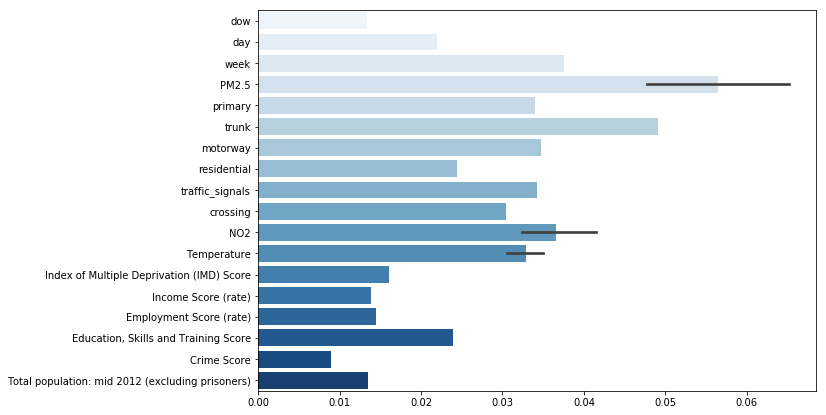

In [8]:
x = e.scores.loc[4,'f_imp'][0]
y = e.scores.loc[4,'f_names']

import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(x=x,y=y, ax=ax, palette='Blues');